# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

In [200]:
# Import the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


# Load the dataset
crops = pd.read_csv("soil_measures.csv")

# Exploratory Data Analysis

In [201]:
# Check the shape of the dataset
print(f'Number of rows: {crops.shape[0]}')
print('\n')
print(f'Number of columns: {crops.shape[1]}')

Number of rows: 2200


Number of columns: 5


In [202]:
# Inspect the first 10 rows of the dataset
crops.head(10)

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice
5,69,37,42,7.073454,rice
6,69,55,38,5.700806,rice
7,94,53,40,5.718627,rice
8,89,54,38,6.685346,rice
9,68,58,38,6.336254,rice


In [203]:
# Check the number of missing values per feature, including the target variable
crops.isna().sum()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [204]:
# Check the different crop types, present in the dataset
crops['crop'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

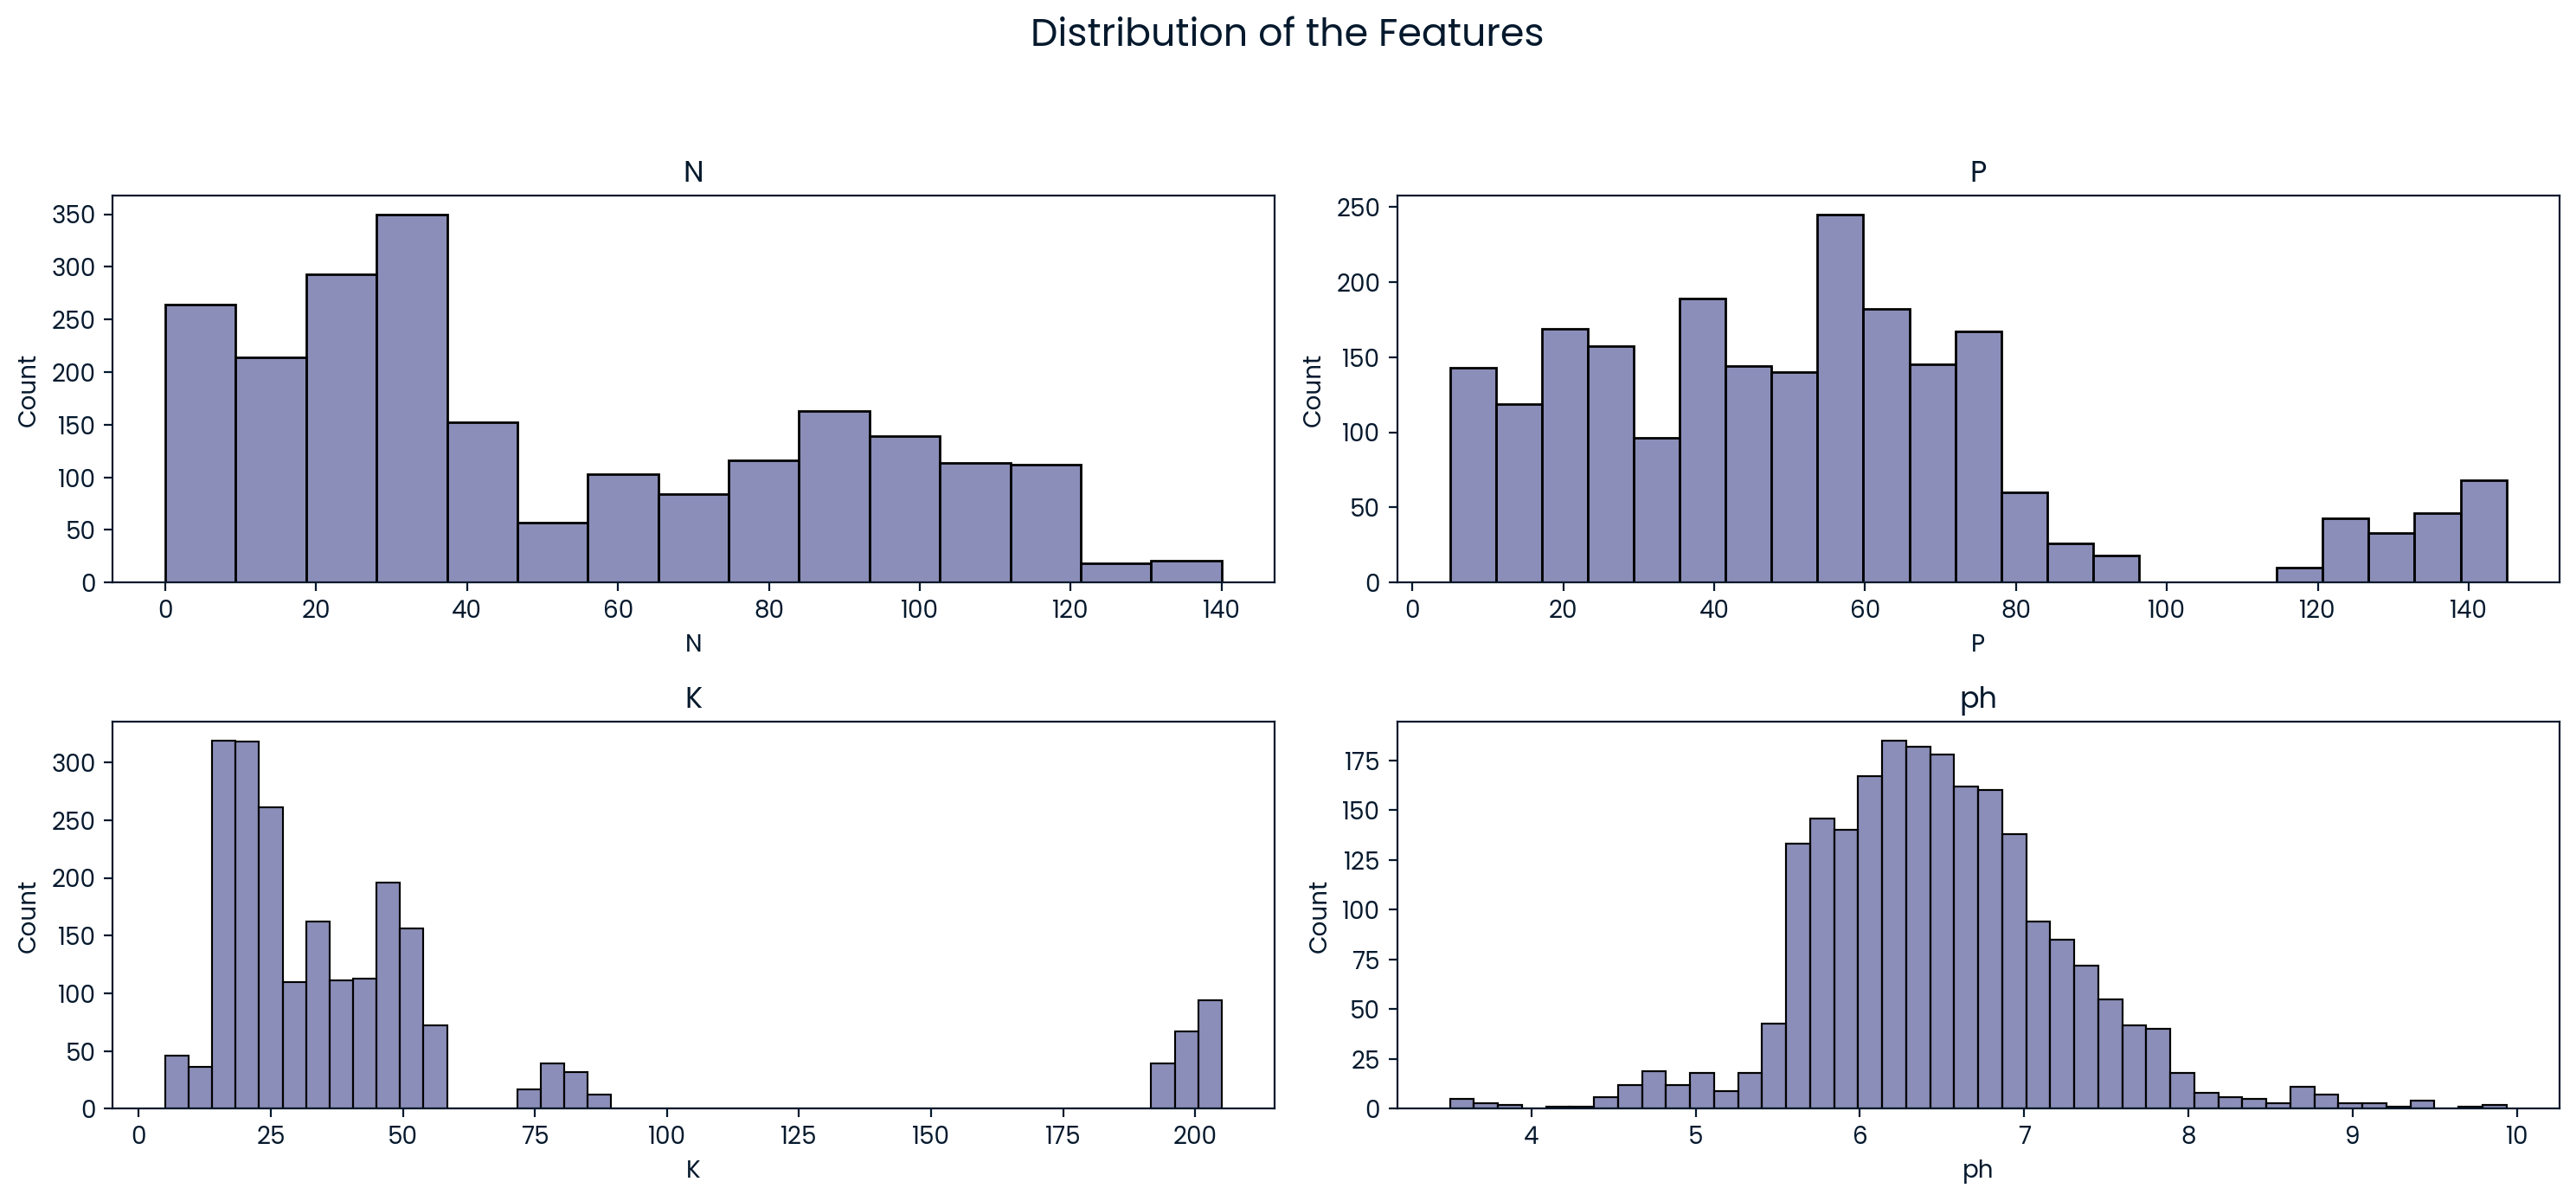

In [205]:
# Check the distribution of the features
features = ['N', 'P', 'K', 'ph']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(crops[feature], kde=False)
    plt.title(feature)
    plt.grid(False)

plt.suptitle('Distribution of the Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

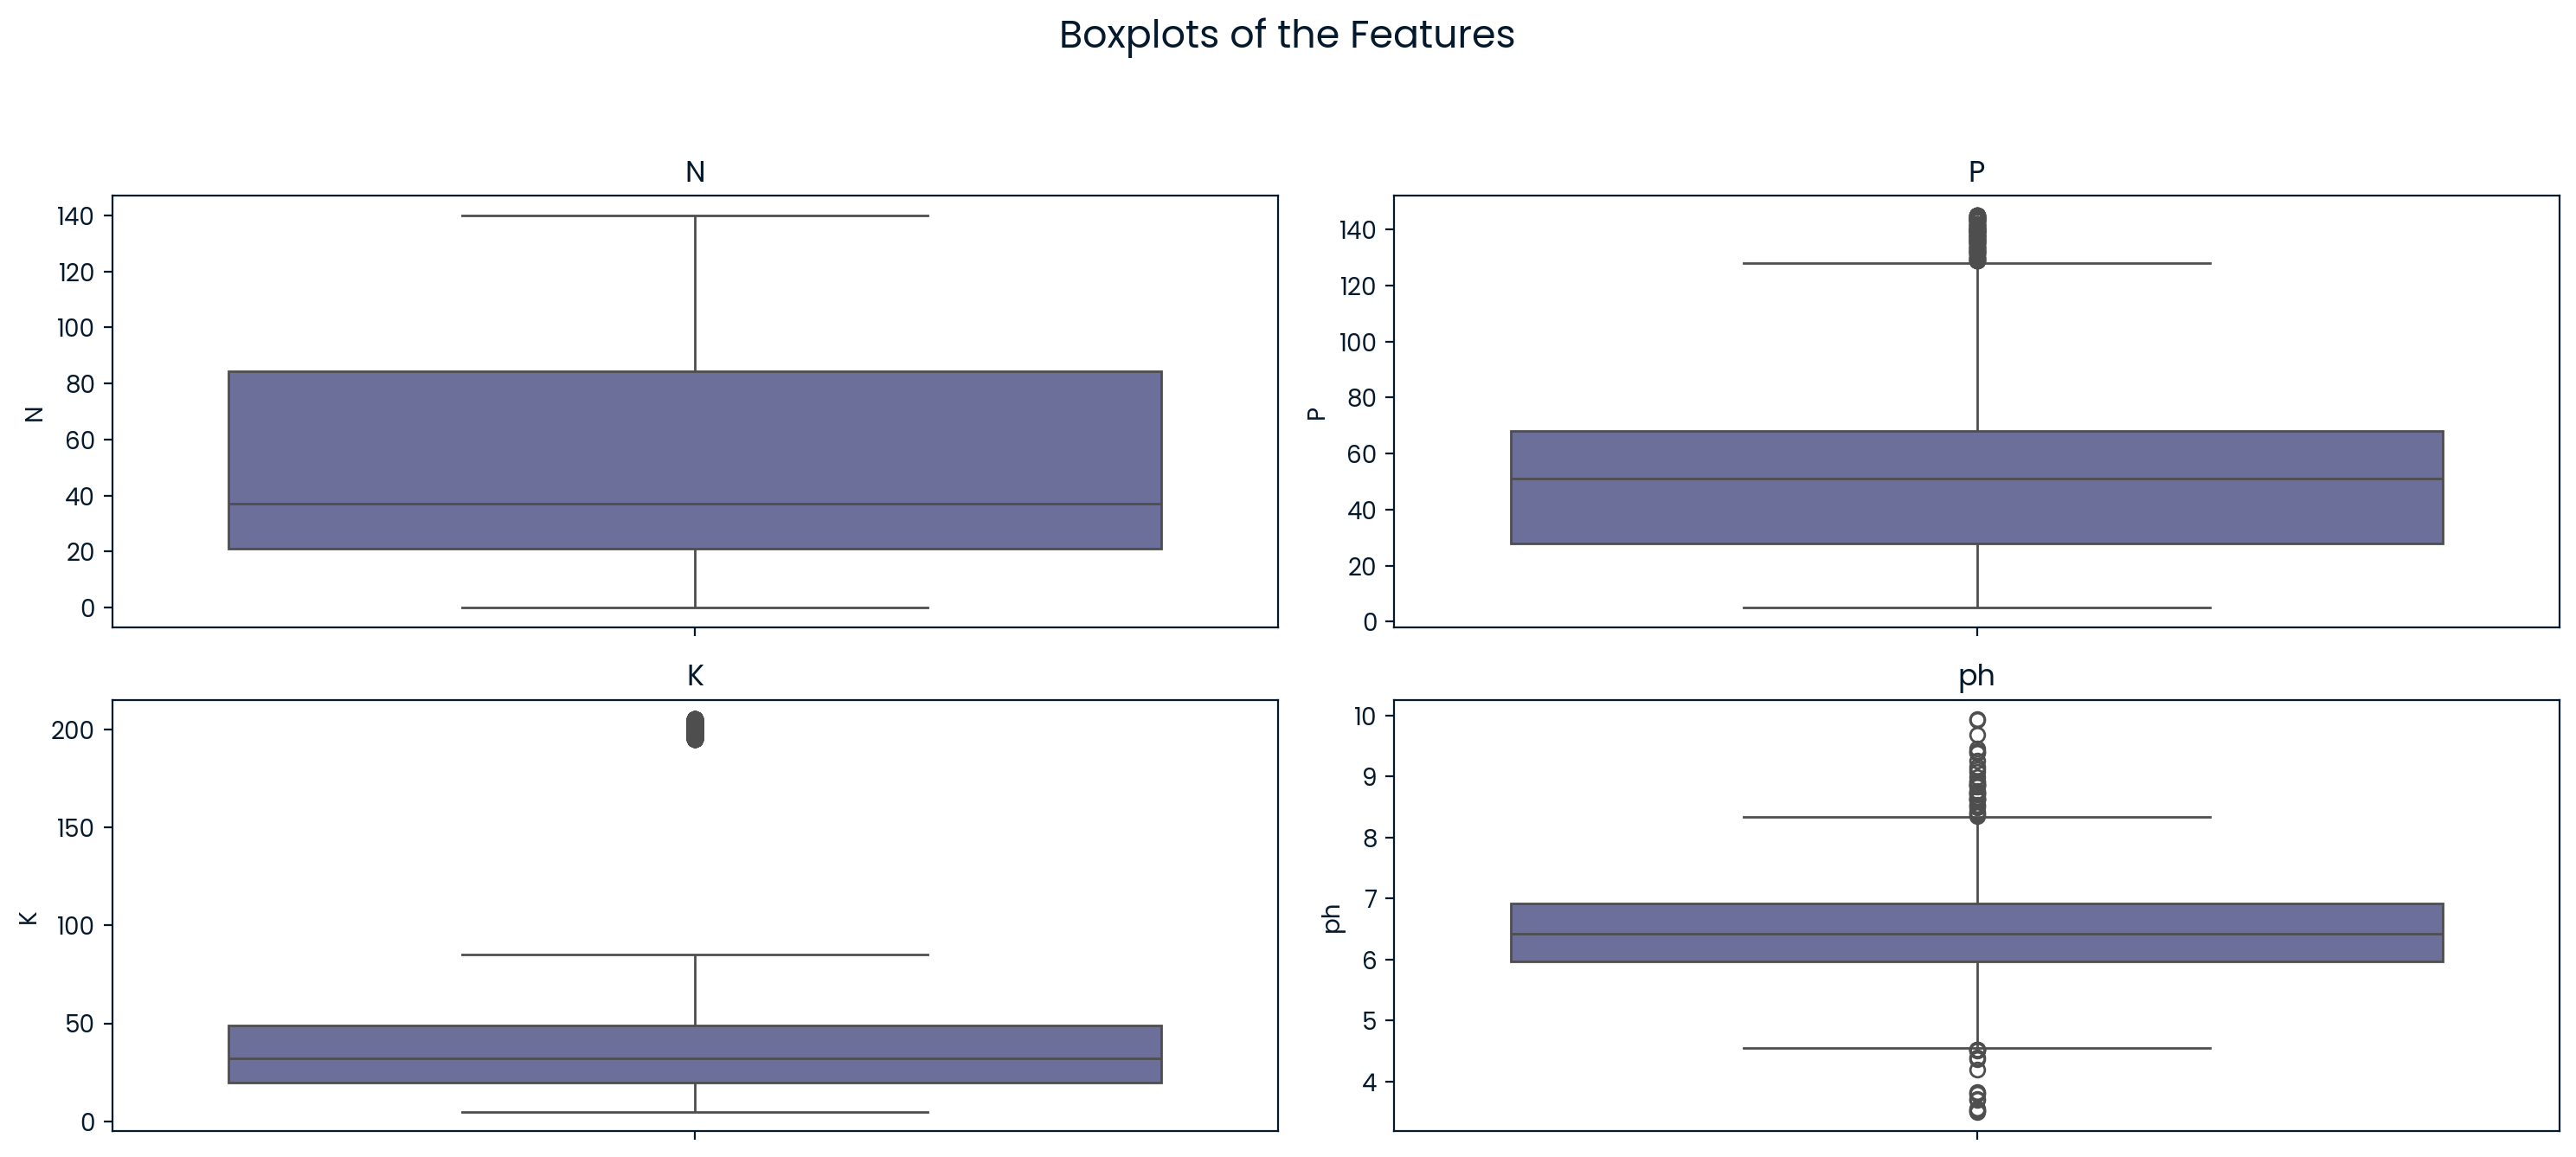

In [206]:
# Check the presence of outliers, present in the features (for possible removal/handling)
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=crops[feature])
    plt.title(feature)
    plt.grid(False)

plt.suptitle('Boxplots of the Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Note**: Although outliers (determined as values beyond ±1.5*IQR) are present in the features, they were retained because they were numerous and closely clustered together.

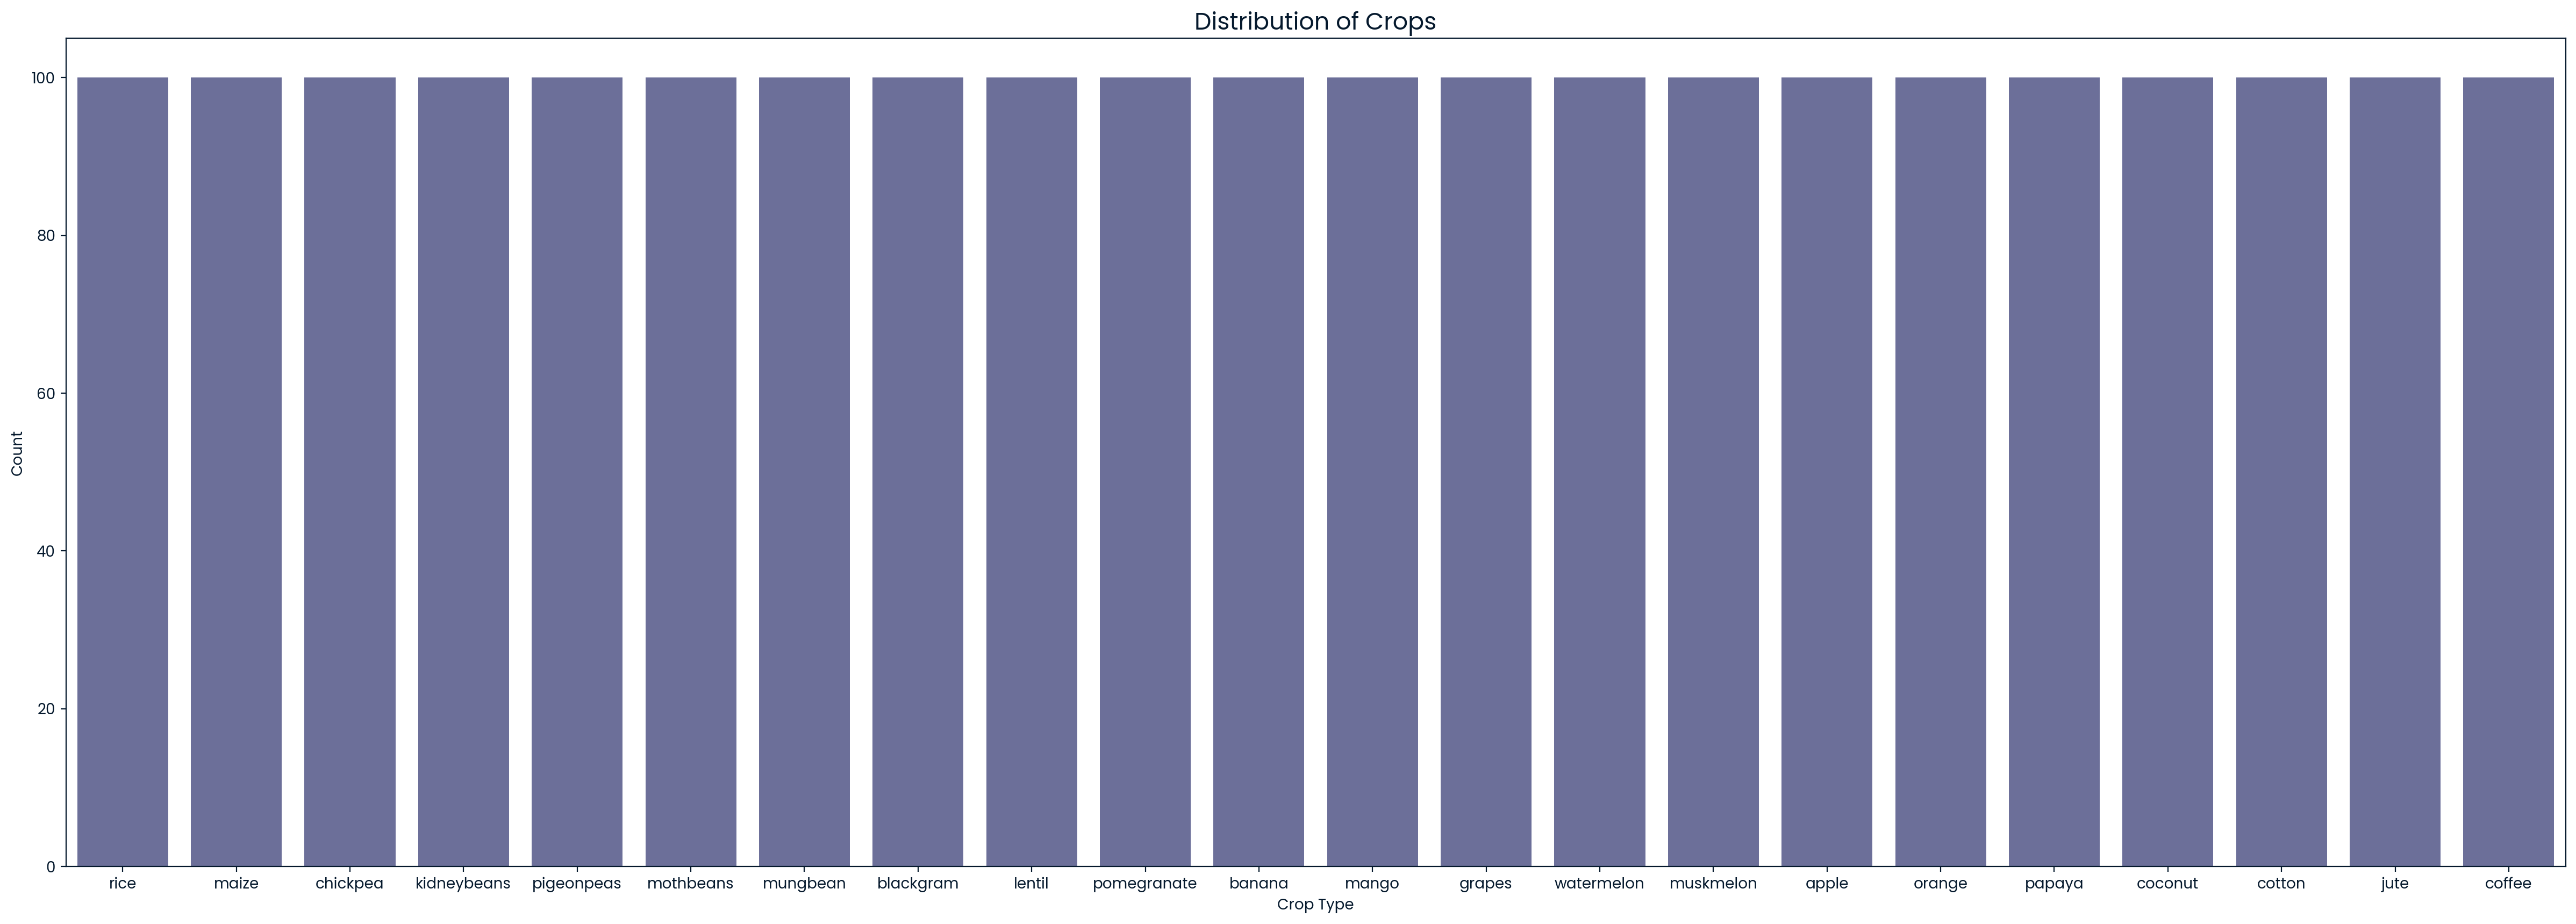

In [207]:
# Check the distribution of the target
plt.figure(figsize=(30, 10))
sns.countplot(data=crops, x='crop')
plt.title('Distribution of Crops', fontsize=16)
plt.grid(False)
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.show()

In [208]:
# As the plot is very tight, let's see a little better
crops['crop'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: crop, dtype: int64

**Note**: Since the target variable is perfectly balanced, the accuracy can be used as an evaluation metric.

# Splitting the Data

In [209]:
# Splitting the data into features (X) and target (y)
X = crops[['N', 'P', 'K', 'ph']]
y = crops['crop']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Display the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1760, 4)
X_test shape: (440, 4)
y_train shape: (1760,)
y_test shape: (440,)


# Evaluate Feature Performance

In [210]:
# Normalize the features, with a MinMaxScaler object fitted exclusively on the train dataset to avoid data leakage
# NOTE: I decided to normalize the features (min=0, max=1) instead of standardizing (avg=0, std=1), because of the fact that not all features' histograms exhibit a behavior close to the Normal Distribution (ideal for feature standardization)

# Normalizing the features with MinMaxScaler
scaler = MinMaxScaler()

# Fitting the scaler on the training data and transforming the training data
X_train_normalized = scaler.fit_transform(X_train)

# Transforming the test data with the scaler fitted on the training data
X_test_normalized = scaler.transform(X_test)

# Calculating the Maximum and Minimum for the normalized training data
train_max = np.max(X_train_normalized, axis=0)
train_min = np.min(X_train_normalized, axis=0)

# Calculating the Maximum and Minimum for the normalized testing data
test_max = np.max(X_test_normalized, axis=0)
test_min = np.min(X_test_normalized, axis=0)

# Display the Maximum and Minimum of the normalized features
print("Maximum of normalized training features:\n", train_max)
print("Minimum of normalized training features:\n", train_min)
print("\nMaximum of normalized testing features:\n", test_max)
print("Minimum of normalized testing features:\n", test_min)

Maximum of normalized training features:
 [1. 1. 1. 1.]
Minimum of normalized training features:
 [0. 0. 0. 0.]

Maximum of normalized testing features:
 [1.         1.         1.         0.91785764]
Minimum of normalized testing features:
 [0.         0.         0.         0.00423871]


## Logistic Regression

In [211]:
# Dictionary to store models and their accuracy (predictive performance)
models_logistic_regression = {}

for feature in features:
    
    # Train model using only one feature
    X_train_feature = X_train_normalized[:, [features.index(feature)]]
    X_test_feature = X_test_normalized[:, [features.index(feature)]]

    # Logistic Regession with default hyerparameters
    model = LogisticRegression()
    model.fit(X_train_feature, y_train)

    # Predict and calculate accuracy
    y_pred = model.predict(X_test_feature)
    accuracy = accuracy_score(y_test, y_pred)

    # Store model and accuracy
    models_logistic_regression[feature] = {'model': model, 'accuracy': accuracy}

    print(f"Feature: {feature}")
    print(f"Accuracy: {accuracy:.4f}\n")

Feature: N
Accuracy: 0.1455

Feature: P
Accuracy: 0.2023

Feature: K
Accuracy: 0.1955

Feature: ph
Accuracy: 0.0682



**Note**: Since there is no clear best feature with the Logistic Regression (the performances of P and K are very close), I decided to try a Decision Tree classifier.

## Decision Tree

In [212]:
# Dictionary to store models and their accuracy (predictive performance)
models_decision_tree = {}

for feature in features:
    
    # Train model using only one feature
    X_train_feature = X_train_normalized[:, [features.index(feature)]]
    X_test_feature = X_test_normalized[:, [features.index(feature)]]

    # Decision Tree Classifier with default hyerparameters
    model = DecisionTreeClassifier()
    model.fit(X_train_feature, y_train)

    # Predict and calculate accuracy
    y_pred = model.predict(X_test_feature)
    accuracy = accuracy_score(y_test, y_pred)

    # Store model and accuracy
    models_decision_tree[feature] = {'model': model, 'accuracy': accuracy}

    print(f"Feature: {feature}")
    print(f"Accuracy: {accuracy:.4f}\n")

Feature: N
Accuracy: 0.1773

Feature: P
Accuracy: 0.1795

Feature: K
Accuracy: 0.3000

Feature: ph
Accuracy: 0.1136



# Create the best_predictive_feature variable

In [213]:
# How the dictionary of models currently looks like, using the one obtained from the Decision Tree as now we have a clear winner
models_decision_tree

{'N': {'model': DecisionTreeClassifier(), 'accuracy': 0.17727272727272728},
 'P': {'model': DecisionTreeClassifier(), 'accuracy': 0.17954545454545454},
 'K': {'model': DecisionTreeClassifier(), 'accuracy': 0.3},
 'ph': {'model': DecisionTreeClassifier(), 'accuracy': 0.11363636363636363}}

In [214]:
# Find the best predictive feature, with the highest accuracy
best_feature = max(models_decision_tree, key=lambda feature: models[feature]['accuracy'])
best_accuracy = models_decision_tree[best_feature]['accuracy']

# Create the dictionary with the best feature and its accuracy
best_predictive_feature = {best_feature: best_accuracy}

# Display the best feature and its accuracy
print("Best Predictive Feature and its Accuracy:")
print(best_predictive_feature)

Best Predictive Feature and its Accuracy:
{'K': 0.3}
